# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Decision Tree, and will then apply a Decision Tree classsifier on the MNIST hand written digits dataset that we already saw.


## Suboptimality of ID3
Consider the following training set, where $\mathcal{X} = \{0, 1\}^3$ and $\mathcal{Y} =\{0, 1\}$:

$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
((0, 0, 1), 0)
\end{aligned}
$$

Suppose we wish to use this training set in order to build a decision tree of depth 2 (i.e. for each
input we are allowed to ask two questions of the form "$x_i = 0$?" before deciding on the label).

1. Suppose we run the ID3 algorithm up to depth 2 (namely, we pick the root node and its
children according to the algorithm, but instead of keeping on with the recursion, we stop
and pick leaves according to the majority label in each subtree, once we reach depth 2). 
Assume that the subroutine used to measure the quality of each feature is based on the information gain, and that if two features get the same score, one of them is picked arbitrarily. 
Show that the training error of the resulting decision tree is at least 1/4.
2. Find a decision tree of depth 2, which attains zero training error.


#### Answer
Put your answer here...

In [1]:
from IPython.display import Image

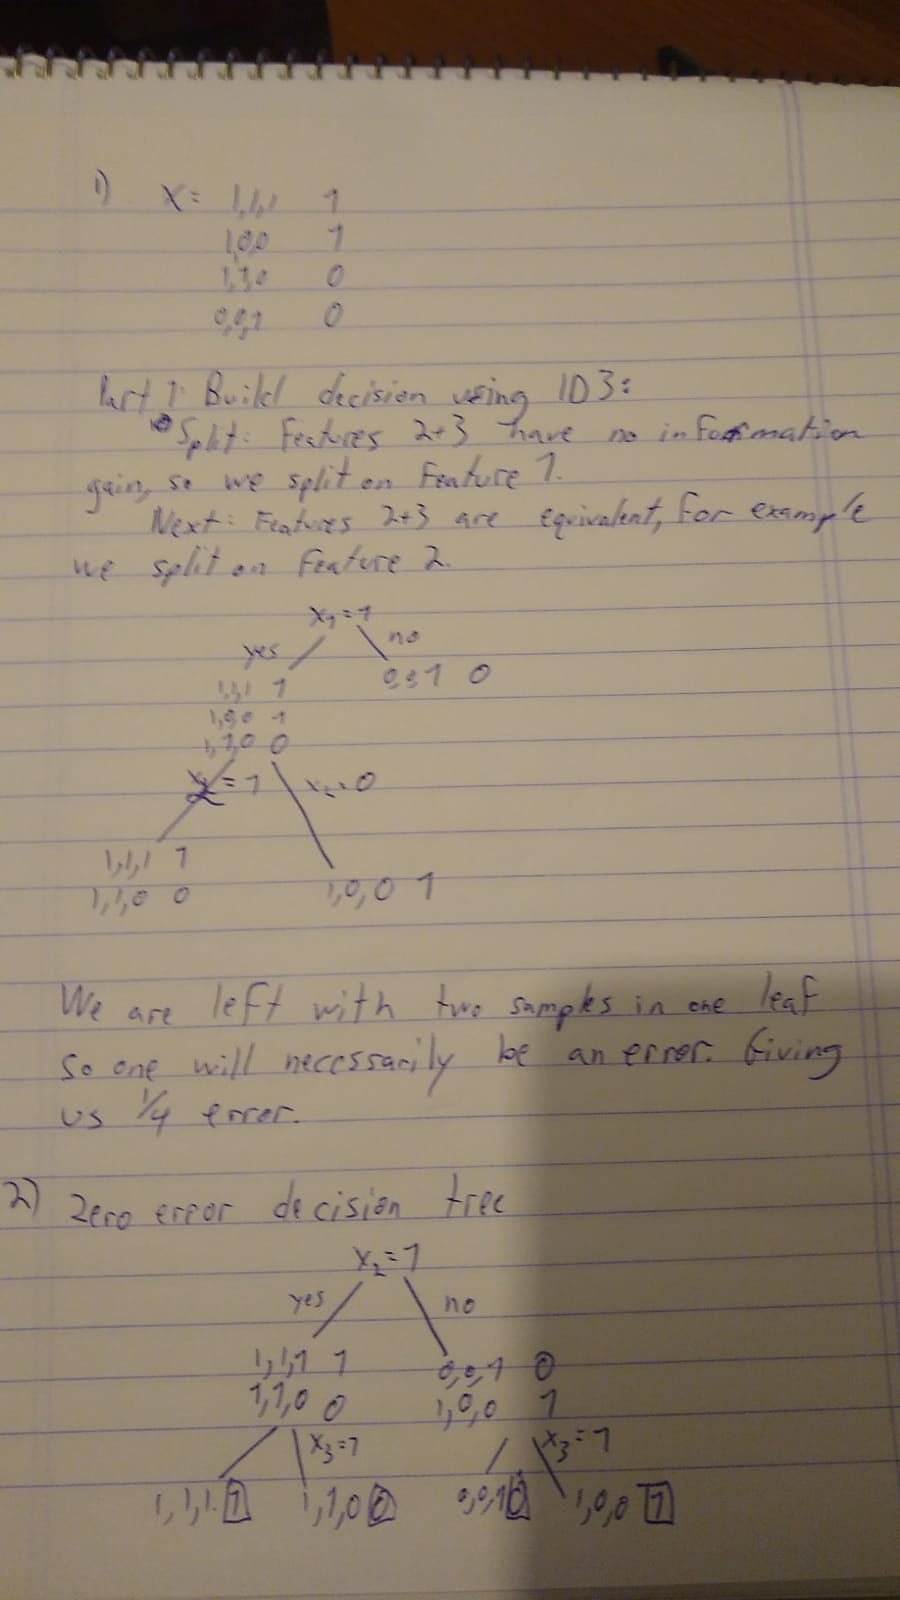

## Implementing Decision Tree From Scratch
In this exercise you will need to implement a simple version of Decision Tree from scratch. Your decision tree will handle **continuous input and output** (this should actually work also for binary input attributes).

* Compelete the skeleton class below
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `min_leaf` is the minimal number of samples in each leaf node
  
* For splitting criterion, use either **"Train Squared Error Minimization (Reduction in Variance)"** or **"Train Absolute Error Minimization"** (choose one). Whatever you choose, make sure you implement the splitting point decision efficiently (in $O(nlgn)$ time).

* The `predict` function will use mean of the target values in the leaf node matching each row of the given `X`. The result is a vector of predictions matching the number of rows in `X`.

* To check your decision tree implementation, use the boston dataset (`from sklearn.datasets import load_boston`) split the data set into train and test using (`from sklearn.model_selection import train_test_split`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
    for min_leaf in [1,5,10,100]:
      dt = DecisionTree(X, y, n, sz, min_leaf)
      mse = # mean square error over test set
      print("min_leaf:{0} --- oob mse: {1}".format(min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = dt.predict(X_train)  # forest is the chosen model
  plt.scatter(y_hat, y_test)
  ```

In [121]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


from sklearn.datasets import load_boston
X,y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
n_trees=5
sample_sz=20
min_lf = 10
min_leaf = 1

In [12]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [126]:



class DecisionTree():
    
    def __init__(self):
#         self.n_trees,self.sample_sz,self.min_leaf= n_trees, sample_sz, min_leaf
        self.tree=[]
    @staticmethod
    def sse(samples):
        return np.var(samples)*len(samples)
    
    def make_a_split(self,sampleX,sampleY,min_leaf,sample_sz):
        cutoffs=list()
        # make a list of cutoffs using "sample_sz" unique values for each feature
        for feature in sampleX.T:   
            unique_cutoffs=np.unique(feature)[:-1]
            cutoffs.append(np.random.choice(unique_cutoffs,replace=False,size=min(sample_sz,len(unique_cutoffs))))
        # calculate the sse resulting from each split
        variances = np.ones((sampleX.shape[1],sample_sz))*self.sse(sampleY)
        for feature,cutoff_array in enumerate(cutoffs):
            for sample,cutoff in enumerate(cutoff_array):
                variances[feature,sample]=np.nansum([self.sse(sampleY[sampleX[:,feature]<=cutoff]),self.sse(sampleY[sampleX[:,feature]>cutoff])])
                np.nansum([self.sse(sampleY[sampleX[:,feature]<=cutoff]),self.sse(sampleY[sampleX[:,feature]>cutoff])])
        # choose the feature and threshold that minimize the variance
        feature,cutoff_num = np.unravel_index(variances.argmin(), variances.shape)
        cutoff_point = cutoffs[feature][cutoff_num]
        f_c = [feature,cutoff_point]
        index1=sampleX[:,feature]>cutoff_point
        index2=sampleX[:,feature]<=cutoff_point
        X1,X2,y1,y2 = sampleX[index1,:],sampleX[index2,:],sampleY[index1],sampleY[index2]
        return X1,y1,X2,y2,f_c
    
    def split_recursive(self,X,y,sample_sz,min_leaf,n_trees,coords=[],list_of_cutoffs=[]):
        # split recursively and add the feature and cutoff for each split, along with 'a' for right and 'b' for left
        X1,y1,X2,y2,f_c=self.make_a_split(X,y,min_leaf,sample_sz)
# keep splitting as these conditions are met
        if len(y1)>min_leaf and len(list_of_cutoffs)<(n_trees-1):
            self.split_recursive(X1,y1,sample_sz,min_leaf,n_trees,coords=coords+['a'],list_of_cutoffs=list_of_cutoffs+[f_c])
        else:
# when we stop splitting, add the cutoffs, list of coordinates (right and left) and the mean of the leaf into the tree
            self.tree.append([list_of_cutoffs+[f_c],coords+['a'],y1.mean()])
# do the same for other side of the split
        if len(y2)>min_leaf and len(list_of_cutoffs)<(n_trees-1):
            self.split_recursive(X2,y2,sample_sz,min_leaf,n_trees,coords=coords+['b'],list_of_cutoffs=list_of_cutoffs+[f_c])
        else:
            self.tree.append([list_of_cutoffs+[f_c],coords+['b'],y2.mean()])
    
    def predict(self,x2check):
        for leaf in self.tree:
            stop=False
            for n,pair in enumerate(leaf[0]):
                if stop==False:
                    # go through each node in the leaf, if it matches continue if not try the next leaf
                    if (x2check[pair[0]]>pair[1] and leaf[1][n]=="a") or (x2check[pair[0]]<=pair[1] and leaf[1][n]=="b") :
                        # if we have gotten to the end of the leaf and it is all correct, predict the leaf mean
                        if n==len(leaf[0])-1:
                            return (leaf[2])
                    else:
                        stop = True
    

dt = DecisionTree()
dt.split_recursive(X_train,y_train,20,100,3)

list_y = []
for count, x in enumerate(X_test):
    list_y.append(dt.predict(X_test[count]))
    y_hat = np.asarray(list_y, dtype=np.float32)


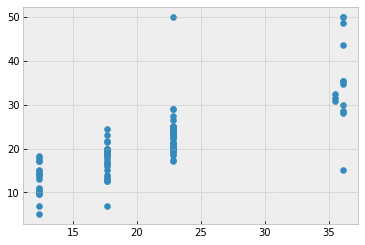

In [127]:
plt.scatter(y_hat, y_test)

## Using Decision Treefor Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
- Choose which model parameters you wish to optimize, explain how would you do that, and find a model which you believe would have the minimal generalization error --- do this for both a single decision tree model, and a random forest.
  - You can use `sklearn.tree.DecisionTreeClassifier`
- Once you are satisfied with the model parameters, plot the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

## 1 Choose which model parameters

In [2]:
import matplotlib as mpl
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict

### Get the  Data

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.shape

(56000, 784)

In [9]:
y_train.shape

(56000,)

### DT Without grid seach

In [10]:
simple_cls_DT = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
simple_cls_DT.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [11]:
y_pred_simple_DT = simple_cls_DT.predict(X_test)

In [12]:
cm = confusion_matrix(y_test, y_pred_simple_DT)
print(cm)
accuracy_score(y_test, y_pred_simple_DT)

[[1239    1   20    4    7   10   19    8   18   17]
 [   1 1541    8    8    4    8    1   12   13    4]
 [  10   17 1201   31   17   14   22   29   29   10]
 [   4   10   44 1207    5   57    8   27   43   28]
 [   4    2   10    9 1136    8   19   13   26   68]
 [  22   15   13   69   12 1042   30    8   39   23]
 [  11    7   23    5   21   28 1261    6   27    7]
 [   4   10   39   16   15    7    2 1368    9   33]
 [   8   18   22   50   35   28   26   12 1118   40]
 [   8    7   14   24   81   31    5   26   25 1199]]


0.8794285714285714

In [13]:
print(confusion_matrix(y_test, y_pred_simple_DT))
print(classification_report(y_test, y_pred_simple_DT))

[[1239    1   20    4    7   10   19    8   18   17]
 [   1 1541    8    8    4    8    1   12   13    4]
 [  10   17 1201   31   17   14   22   29   29   10]
 [   4   10   44 1207    5   57    8   27   43   28]
 [   4    2   10    9 1136    8   19   13   26   68]
 [  22   15   13   69   12 1042   30    8   39   23]
 [  11    7   23    5   21   28 1261    6   27    7]
 [   4   10   39   16   15    7    2 1368    9   33]
 [   8   18   22   50   35   28   26   12 1118   40]
 [   8    7   14   24   81   31    5   26   25 1199]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1343
           1       0.95      0.96      0.95      1600
           2       0.86      0.87      0.87      1380
           3       0.85      0.84      0.85      1433
           4       0.85      0.88      0.86      1295
           5       0.85      0.82      0.83      1273
           6       0.91      0.90      0.90      1396
           7       0.91      0.91   

### DT With grid seach

In [14]:
params = {'criterion':['gini','entropy'], 'max_leaf_nodes': list(range(2, 20)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [15]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=19, random_state=42)

In [16]:

y_pred_DT = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred_DT)

0.6652142857142858

In [17]:
print(confusion_matrix(y_test, y_pred_DT))
print(classification_report(y_test, y_pred_DT))

[[1111    0    0   49    3   27   91   40   17    5]
 [   4 1432   16    4    0   10   14   12   76   32]
 [  98   86  815   25   12   18  150  111   32   33]
 [  55   33  169  651   13  168   72   42   48  182]
 [   5    3    3    0  639   27  151   28   30  409]
 [  81   13    1  102   85  567  231   27   57  109]
 [  71   31   21    3   32   28 1098   13   58   41]
 [  45   11   53    3   24    4   58 1187   13  105]
 [   1  105   41   72   28   47  239    2  732   90]
 [   5    3    9   24   24   40  128   43   63 1081]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1343
           1       0.83      0.90      0.86      1600
           2       0.72      0.59      0.65      1380
           3       0.70      0.45      0.55      1433
           4       0.74      0.49      0.59      1295
           5       0.61      0.45      0.51      1273
           6       0.49      0.79      0.61      1396
           7       0.79      0.79   

##### almost random very bad accuracy 

### RD Without grid seach

In [18]:
cls_rnd = RandomForestClassifier(random_state=42)
cls_rnd.fit(X_train, y_train)

y_pred_rnd = cls_rnd.predict(X_test)

print(accuracy_score(y_test, y_pred_rnd))

print(confusion_matrix(y_test, y_pred_rnd))
print(classification_report(y_test, y_pred_rnd))

0.9672857142857143
[[1325    0    4    0    1    1    3    1    6    2]
 [   0 1573    6    8    2    0    0    6    3    2]
 [   4    5 1334    4    5    1    9    8    8    2]
 [   1    0   23 1366    0    9    0   14   12    8]
 [   4    1    3    0 1257    0    2    3    3   22]
 [   1    3    3   17    4 1226    8    1    8    2]
 [   4    1    0    0    6   10 1372    0    3    0]
 [   3    5   15    0    7    1    0 1455    2   15]
 [   1    6    9   15    6   11    5    7 1290    7]
 [   4    6    5   16   20    5    1   10    9 1344]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1343
           1       0.98      0.98      0.98      1600
           2       0.95      0.97      0.96      1380
           3       0.96      0.95      0.96      1433
           4       0.96      0.97      0.97      1295
           5       0.97      0.96      0.97      1273
           6       0.98      0.98      0.98      1396
           7     

In [19]:
simple_cls_rnd = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
simple_cls_rnd.fit(X_train, y_train)

y_pred_simple_rnd = simple_cls_rnd.predict(X_test)

print(accuracy_score(y_test, y_pred_simple_rnd))

print(confusion_matrix(y_test, y_pred_simple_rnd))
print(classification_report(y_test, y_pred_simple_rnd))

0.8276428571428571
[[1301    2    2    4    1    0   12    2   18    1]
 [   0 1564    3   12    1    2    1    9    7    1]
 [  35   56 1148   19   12    0   34   44   16   16]
 [  24   48   36 1188    5    8    8   40   30   46]
 [  10    6    8    1 1038    0   33   13   14  172]
 [  90   53    5  273   51  624   33   24   35   85]
 [  40   28   49    7   35    8 1213    8    8    0]
 [  10   37   28    1   22    1    0 1330   11   63]
 [   6  115   23   96   16    4   24   10 1006   57]
 [  17   18   10   16   60    1    7   95   21 1175]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1343
           1       0.81      0.98      0.89      1600
           2       0.88      0.83      0.85      1380
           3       0.73      0.83      0.78      1433
           4       0.84      0.80      0.82      1295
           5       0.96      0.49      0.65      1273
           6       0.89      0.87      0.88      1396
           7     

### RD With grid seach

In [20]:
params = {'criterion':['gini','entropy'], 'max_leaf_nodes': list(range(2, 20)), 'min_samples_split': [2, 3, 4]}
grid_search_cv_rf = GridSearchCV(RandomForestClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv_rf.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [21]:
y_pred_grid_rf = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred_grid_rf)

0.6652142857142858

In [22]:
np.sum(y_pred_grid_rf == y_test) / len(y_pred_grid_rf)  # very similar predictions

0.6652142857142858

In [23]:
print(confusion_matrix(y_test, y_pred_grid_rf))
print(classification_report(y_test, y_pred_grid_rf))

[[1111    0    0   49    3   27   91   40   17    5]
 [   4 1432   16    4    0   10   14   12   76   32]
 [  98   86  815   25   12   18  150  111   32   33]
 [  55   33  169  651   13  168   72   42   48  182]
 [   5    3    3    0  639   27  151   28   30  409]
 [  81   13    1  102   85  567  231   27   57  109]
 [  71   31   21    3   32   28 1098   13   58   41]
 [  45   11   53    3   24    4   58 1187   13  105]
 [   1  105   41   72   28   47  239    2  732   90]
 [   5    3    9   24   24   40  128   43   63 1081]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1343
           1       0.83      0.90      0.86      1600
           2       0.72      0.59      0.65      1380
           3       0.70      0.45      0.55      1433
           4       0.74      0.49      0.59      1295
           5       0.61      0.45      0.51      1273
           6       0.49      0.79      0.61      1396
           7       0.79      0.79   

## 2 Importance of each of the pixels

In [25]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [27]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

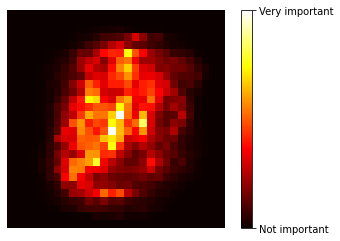

In [28]:
import matplotlib.pyplot as plt 

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

## 3 Estimate the class assignment probabilities

In [29]:
y_test_pred = cross_val_predict(rnd_clf, X_test, y_test, cv=3)
y_test_pred.shape

(14000,)

In [30]:
y_test.shape

(14000,)

In [31]:
conf_m = confusion_matrix(y_test, y_test_pred)
conf_m

array([[1312,    0,    6,    1,    1,    2,    7,    1,   12,    1],
       [   0, 1572,    5,    9,    2,    2,    0,    5,    3,    2],
       [   6,    7, 1294,   12,    9,    3,   13,   18,   14,    4],
       [   1,    2,   32, 1320,    2,   25,    4,   17,   15,   15],
       [   5,    0,    4,    0, 1211,    0,   13,    5,    8,   49],
       [   9,    7,    3,   33,    8, 1185,   12,    3,   10,    3],
       [   6,    2,    1,    0,    8,   15, 1361,    0,    3,    0],
       [   5,   10,   20,    2,   10,    1,    0, 1418,    9,   28],
       [   4,   16,   10,   26,   11,   19,   15,    7, 1233,   16],
       [   9,    7,    4,   16,   28,    8,    1,   20,   10, 1317]])

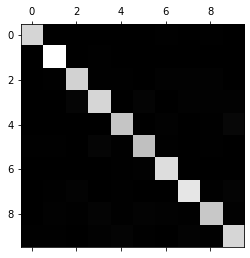

In [32]:
plt.matshow(conf_m, cmap=plt.cm.gray)
plt.show()

In [33]:
row_sums = conf_m.sum(axis=1, keepdims=True)
norm_conf_m = conf_m / row_sums

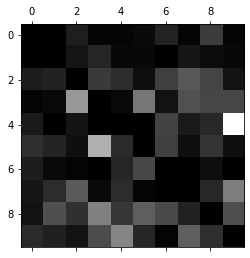

In [34]:
# missmatch
np.fill_diagonal(norm_conf_m, 0)
plt.matshow(norm_conf_m, cmap=plt.cm.gray)
plt.show()

## Discuss  results.

2 mains misclassification are observed:
- 4 and 9 (specialy 9 misclassified as 4)
- 3 and 5 
this is due to the close forme they have

Also the 8 column in is generale are brigher then other number, which mean that many images get misclassified as 8s. 
